# First Attempt
batch size 256 lr 1e-3

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.


## Options

In [2]:
classTrainFeatures = basic_features
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 10000
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'PRI_tau_pt', 'DER_deltar_tau_lep', 'PRI_jet_leading_eta', 'PRI_lep_eta', 'PRI_tau_eta', 'DER_lep_eta_centrality', 'DER_mass_jet_jet', 'DER_deltaeta_jet_jet', 'DER_pt_tot', 'DER_met_phi_centrality', 'PRI_jet_num', 'PRI_met', 'DER_pt_h', 'DER_pt_ratio_lep_tau', 'DER_sum_pt', 'PRI_jet_leading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_all_pt', 'PRI_met_sumet', 'DER_prodeta_jet_jet', 'PRI_lep_pt', 'PRI_jet_subleading_pt', 'PRI_met_phi', 'PRI_jet_leading_phi', 'PRI_lep_phi', 'PRI_jet_subleading_phi', 'PRI_tau_phi']


## Import data

In [3]:
trainData = h5py.File(dirLoc + 'train.hdf5', "r+")
valData = h5py.File(dirLoc + 'val.hdf5', "r+")

## Determine LR

In [ ]:
lrFinder = batchLRFindClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, lrBounds=[1e-5,0.1], trainOnWeights=False, verbose=0)

In [4]:
compileArgs['lr'] = 1e-2

## Train classifier

Using cosine annealing
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 0.402403037214
2 New best found: 0.386308960412
3 New best found: 0.374857893887
6 New best found: 0.370410495221
7 New best found: 0.367979572846
13 New best found: 0.365295767963
14 New best found: 0.363423539165
15 New best found: 0.363021696682
27 New best found: 0.362181445835
28 New best found: 0.360787769333
29 New best found: 0.36028305577
30 New best found: 0.359871270161
31 New best found: 0.359771207854
Early stopping after 51 epochs
Score is: {'loss': 0.35977120785386202, 'AUC': 0.09162619609857614, 'wAUC': 0.068177229234880898}
Fold took 50.554s

Running fold 2 / 10
1 New best found: 0.401466186983
2 New best found: 0.3954339803
3 New best found: 0.3776173208
6 New best found: 0.372722433447
7 New best found: 0.37017106431
13 New best found: 0.368276503766
14 New best found: 0.365756934153
15 New best found: 0.365299623014
26 New best found: 0.364280001431
28 New best foun

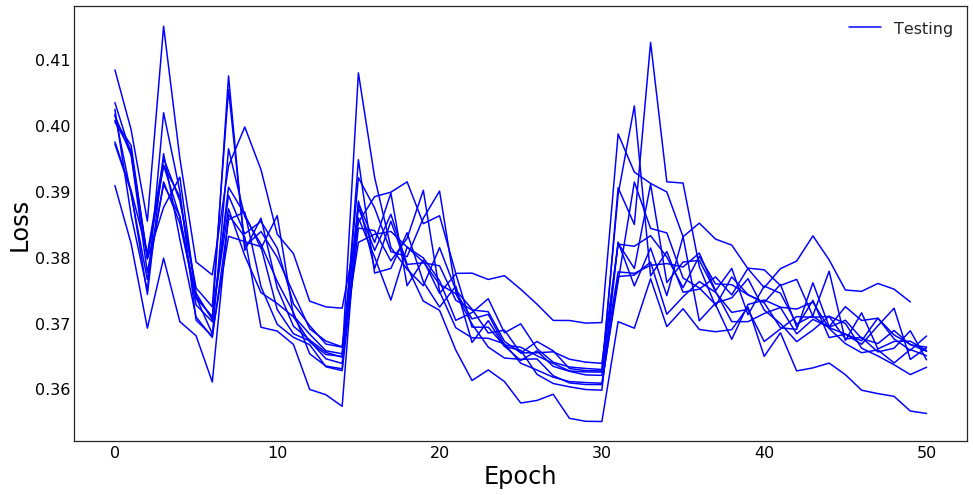

Mean wAUC = 0.0699 +- 0.0007
______________________________________



In [5]:
results, histories = batchTrainClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, cosAnnealMult=2, trainOnWeights=False, patience=20, maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [6]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [7]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

Choosing ensemble by loss
Model 0 is 5 with loss = 0.355011625254
Model 1 is 0 with loss = 0.359771207854
Model 2 is 4 with loss = 0.360618851132
Model 3 is 3 with loss = 0.360825641368
Model 4 is 1 with loss = 0.362022802186
Model 5 is 6 with loss = 0.362517539818
Model 6 is 7 with loss = 0.362695408753
Model 7 is 8 with loss = 0.362913188764
Model 8 is 2 with loss = 0.36384908696
Model 9 is 9 with loss = 0.36995502036


## Response on development data

In [8]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.000219687325532s per sample

Predicting batch 2 out of 10
Prediction took 0.000162186583759s per sample

Predicting batch 3 out of 10
Prediction took 0.000169419639141s per sample

Predicting batch 4 out of 10
Prediction took 0.000171050560474s per sample

Predicting batch 5 out of 10
Prediction took 0.00016795425415s per sample

Predicting batch 6 out of 10
Prediction took 0.000154652559757s per sample

Predicting batch 7 out of 10
Prediction took 0.000169566643238s per sample

Predicting batch 8 out of 10
Prediction took 0.000194052146836s per sample

Predicting batch 9 out of 10
Prediction took 0.000159578434473s per sample

Predicting batch 10 out of 10
Prediction took 0.000169553472505s per sample



In [9]:
print 'Training ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData)),
                                                            roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData), sample_weight=getFeature('weights', trainData)))

Training ROC AUC: unweighted 0.910574974455, weighted 0.932805065514


## Response on val data

In [10]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00017103061676s per sample

Predicting batch 2 out of 10
Prediction took 0.000173346185684s per sample

Predicting batch 3 out of 10
Prediction took 0.000166399002075s per sample

Predicting batch 4 out of 10
Prediction took 0.00016989197731s per sample

Predicting batch 5 out of 10
Prediction took 0.000163283586502s per sample

Predicting batch 6 out of 10
Prediction took 0.000169540596008s per sample

Predicting batch 7 out of 10
Prediction took 0.000167977428436s per sample

Predicting batch 8 out of 10
Prediction took 0.000169923400879s per sample

Predicting batch 9 out of 10
Prediction took 0.00016845202446s per sample

Predicting batch 10 out of 10
Prediction took 0.000247877597809s per sample



In [11]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData), getFeature('pred', valData)),
                                                           roc_auc_score(getFeature('targets', valData), getFeature('pred', valData), sample_weight=getFeature('weights', valData)))

Testing ROC AUC: unweighted 0.907822952529, weighted 0.929642796981


## Evaluation

### Import in dataframe

In [12]:
def convertToDF(datafile, columns={'gen_target', 'gen_weight', 'pred_class'}, nLoad=-1):
    data = pandas.DataFrame()
    data['gen_target'] = getFeature('targets', datafile, nLoad)
    data['gen_weight'] = getFeature('weights', datafile, nLoad)
    data['pred_class'] = getFeature('pred', datafile, nLoad)
    print len(data), "candidates loaded"
    return data

In [13]:
devData = convertToDF(trainData)
valData = convertToDF(valData)

200000 candidates loaded
50000 candidates loaded


In [14]:
sigVal = (valData.gen_target == 1)
bkgVal = (valData.gen_target == 0)

### MVA distributions

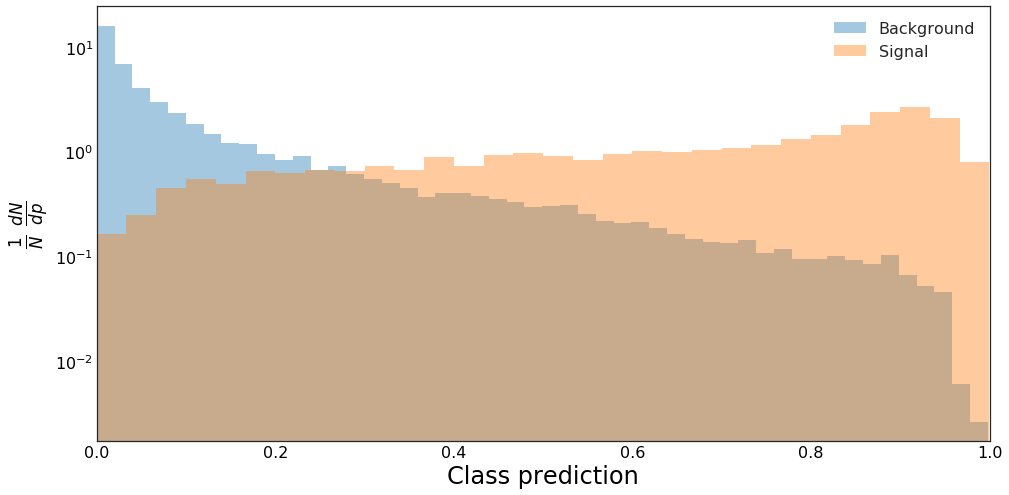

In [15]:
getClassPredPlot([valData[bkgVal], valData[sigVal]], weightName='gen_weight')

In [16]:
def AMS(s, b):
    """ Approximate Median Significance defined as:
        AMS = sqrt(
                2 { (s + b + b_r) log[1 + (s/(b+b_r))] - s}
              )        
    where b_r = 10, b = background, s = signal, log is natural logarithm """
    
    br = 10.0
    radicand = 2 *( (s+b+br) * math.log (1.0 + s/(b+br)) -s)
    if radicand < 0:
        print 'radicand is negative. Exiting'
        exit()
    else:
        return math.sqrt(radicand)
    
def amsScan(inData, res=0.0001):
    best = [0,-1]
    for i in np.linspace(0.,1.,1./res):
        ams = AMS(np.sum(inData.loc[(inData['pred_class'] >= i) & sigVal, 'gen_weight']),
                  np.sum(inData.loc[(inData['pred_class'] >= i) & bkgVal, 'gen_weight']))
        if ams > best[1]:
            best = [i, ams]
    print best

In [17]:
amsScan(valData)

/home/giles/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


[0.84198419841984207, 1.6277706562865253]


## Save classified data

In [ ]:
name = dirLoc + signal + "_" + channel + "_" + varSet + '_' + classModel + '_classifiedData.csv'
print "Saving data to", name
valData.to_csv(name, columns=['gen_target', 'gen_weight', 'gen_sample', 'pred_class'])

## Save/load

In [ ]:
name = "weights/DNN_" + signal + "_" + channel + "_" + varSet + '_' + classModel
print name

### Save

In [ ]:
saveEnsemble(name, ensemble, weights, compileArgs, overwrite=1)

### Load

In [ ]:
ensemble, weights, compileArgs, inputPipe, outputPipe = loadEnsemble(name)